# Siamese Network

I use a Siamese network to identify people. This enables the subsequent recognition and unique identification of people in successive frames. The Siamese network is specifically designed to capture patterns and features in images, helping to highlight the similarities or differences between different people. Using this technique, people can be tracked and identified across different frames, even if their position or pose changes. This is particularly useful for ensuring consistent tracking of people in video sequences and ensuring a clear association between different frames.

In [58]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import re

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [59]:
def extract_first_number(filename):
    # this function extracts the first sequence of digits from the image name. I use it to identify the same people later. 
    match = re.search(r'\d+', filename)
    
    if match:
        return int(match.group())
    else:
        return None
    
def resize_and_pad_image(img, target_size=(128, 128)):
    # this function resizes the image to the target size and pads it with zeros to keep the aspect ratio
    height, width, _ = img.shape

    target_height, target_width = target_size
    aspect_ratio = width / height

    if width == height:
        return cv2.resize(img, target_size)

    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else: 
        new_width = int(target_height * aspect_ratio)
        new_height = target_height

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    top_pad = (target_height - new_height) // 2
    bottom_pad = target_height - new_height - top_pad
    left_pad = (target_width - new_width) // 2
    right_pad = target_width - new_width - left_pad

    padded_img = cv2.copyMakeBorder(resized_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_img

In [100]:
def load_data(path = './Market-1501-v15.09.15/bounding_box_train/'):
    # this function loads the Images from the folder and save there labels 
    files = os.listdir(path)
    files.sort()
    data = []
    label = []

    for file in files[:3000]:
        img = cv2.imread(path + file)
        if img is None:
            print("Could not load file: " + file)
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0

        img_resized = resize_and_pad_image(img, target_size=(128, 128))

        data.append(img_resized)
        label.append(extract_first_number(file))

    data = np.array(data)
    return data, label

In [101]:
iamges, labels = load_data()

In [64]:
def generate_pairs(images, labels, num_pairs):
    anchor, positive, anchor_negative, negative = [], [], [], []

    for _ in range(num_pairs // 2):
        label = np.random.choice(np.unique(labels))
        label_indices = np.where(labels == label)[0]

        if len(label_indices) >= 2:
            idx1, idx2 = np.random.choice(label_indices, size=2, replace=False)
            anchor.append(images[idx1])
            positive.append(images[idx2])

        label1, label2 = np.random.choice(np.unique(labels), size=2, replace=False)
        label1_indices = np.where(labels == label1)[0]
        label2_indices = np.where(labels == label2)[0]
        
        idx1a = np.random.choice(label1_indices)
        idx2a = np.random.choice(label2_indices)
        anchor_negative.append(images[idx1a])
        negative.append(images[idx2a])


    positives = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(anchor),
        tf.convert_to_tensor(positive),
        tf.convert_to_tensor(np.ones(len(anchor), dtype=np.float32))
    ))

    negatives = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(anchor_negative),
        tf.convert_to_tensor(negative),
        tf.convert_to_tensor(np.zeros(len(anchor_negative), dtype=np.float32))
    ))

    return positives, negatives

In [102]:
positives, negatives = generate_pairs(iamges, labels, 1000)

In [103]:
data = positives.concatenate(negatives)

## Build Train and Test Partition

In [104]:
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [105]:
# Training partition
train_data = data.take(round(len(data)*1))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [106]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Build Model

In [18]:
def make_embedding(): 
    inp = Input(shape=(128,128,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [19]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 119, 119, 64)      19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       26

In a Siamese Network is used to evaluate the similarity between two input images. The architecture shown above is used as the base network for extracting embeddings for images in a Siamese Network

In [20]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [21]:
l1 = L1Dist()

The L1Dist class is a custom layer that is used to calculate the L1 distance between the two embeddings.

In [22]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(128,128,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(128,128,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [23]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         86146368    ['input_img[0][0]',              
                                                                  'validation_img[0][

In this code, the Siamese Network is constructed. It takes two input images, an anchor image (input_image) and a validation image (validation_image). The Siamese distance components are combined using an L1 distance layer (L1Dist). This layer computes the distances between the recognized features of the two input images. A Dense layer with one output and a sigmoid activation is used for classification, producing a value between 0 and 1, indicating dissimilarity (0) or similarity (1).

## Train the Model

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 40

In [ ]:
train(train_data, EPOCHS)

In [ ]:
siamese_model.save('./Model/Person_siamese_model_new.h5')

# Load and Test Model

In [27]:
siamese_model_loaded = tf.keras.models.load_model('./Model/Person_siamese_model.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy()})

In [28]:
siamese_model_loaded.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         86146368    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [29]:
siamese_model_loaded.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    loss=tf.losses.BinaryCrossentropy(), 
    metrics=['accuracy']  
)

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [107]:
r = Recall()
p = Precision()
acc = BinaryAccuracy()
scores = []

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    scores.extend(yhat)
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat) 
    acc.update_state(y_true, yhat)


print(f'Recall: {r.result().numpy():.4f}, Precision: {p.result().numpy():.4f}, Accuracy: {accuracy_result:.4f}')

1/1 [==============================] - 2s 2s/step
Recall: 0.7188, Precision: 0.6571, Accuracy: 0.6300


In [108]:
test_batch = test_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y_pred = scores[:len(y)]
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_pred ]

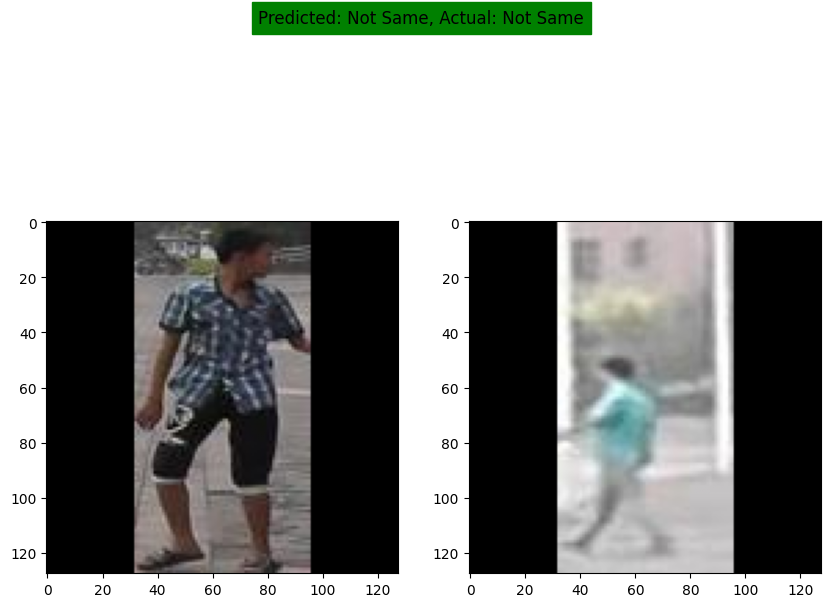

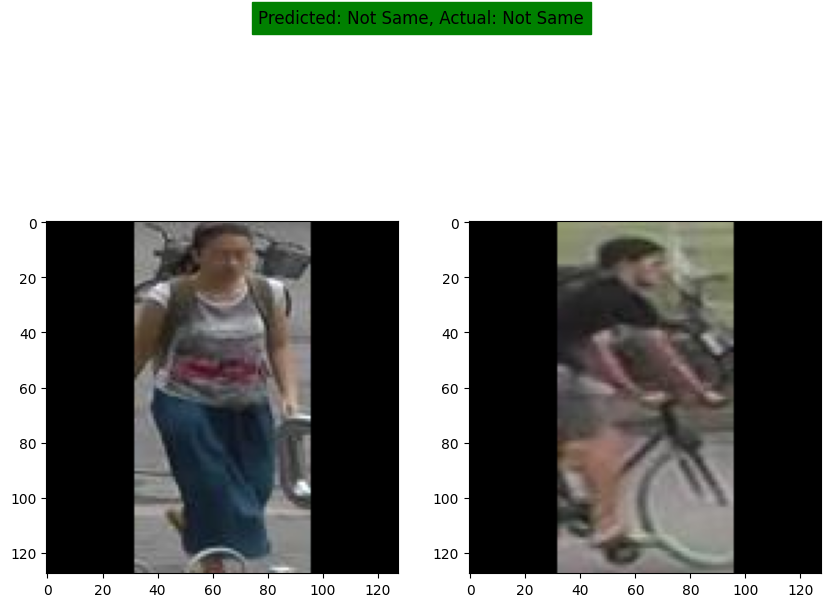

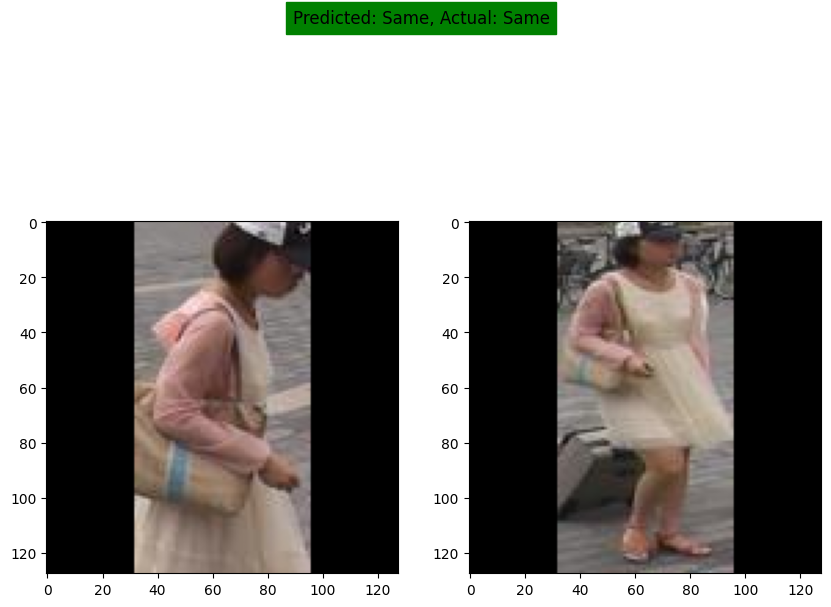

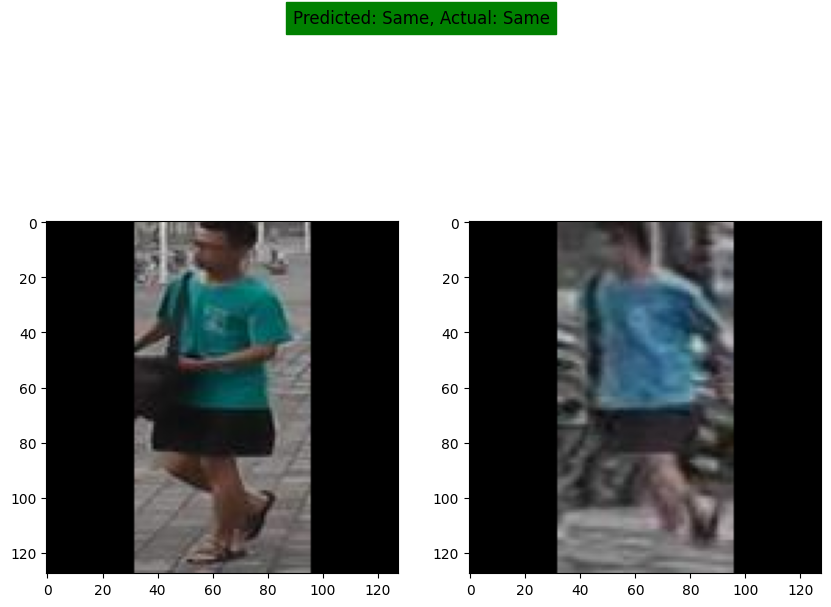

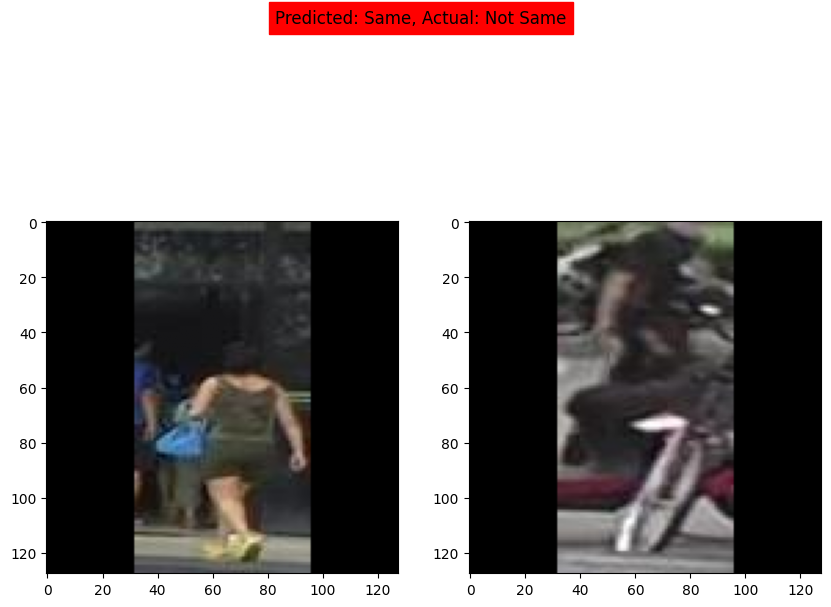

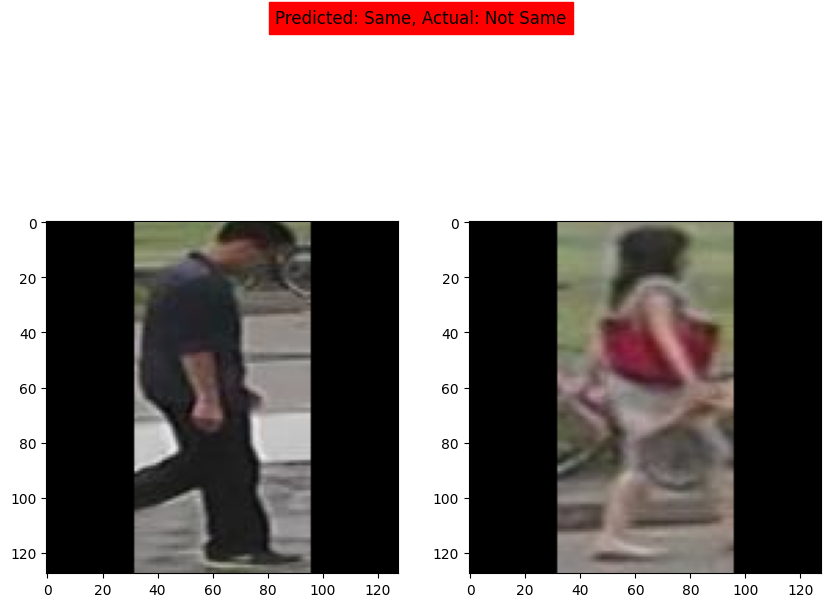

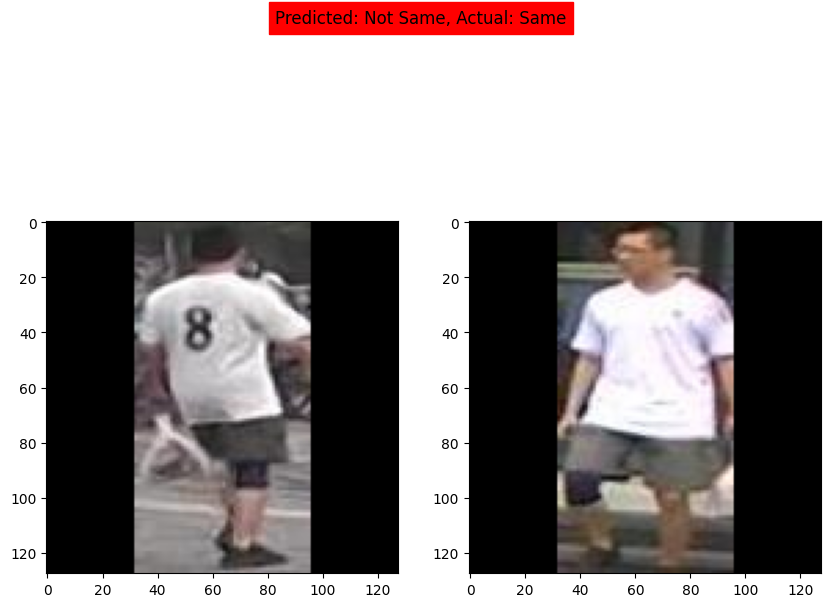

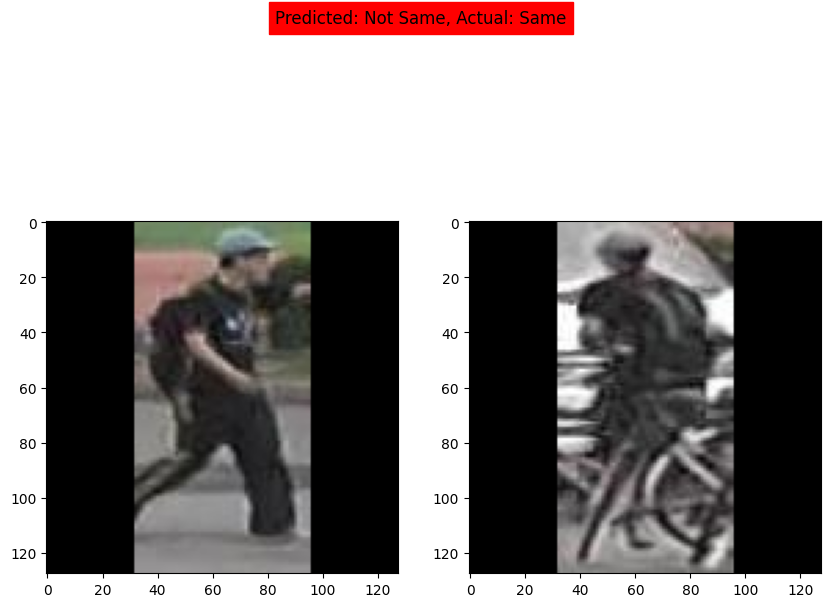

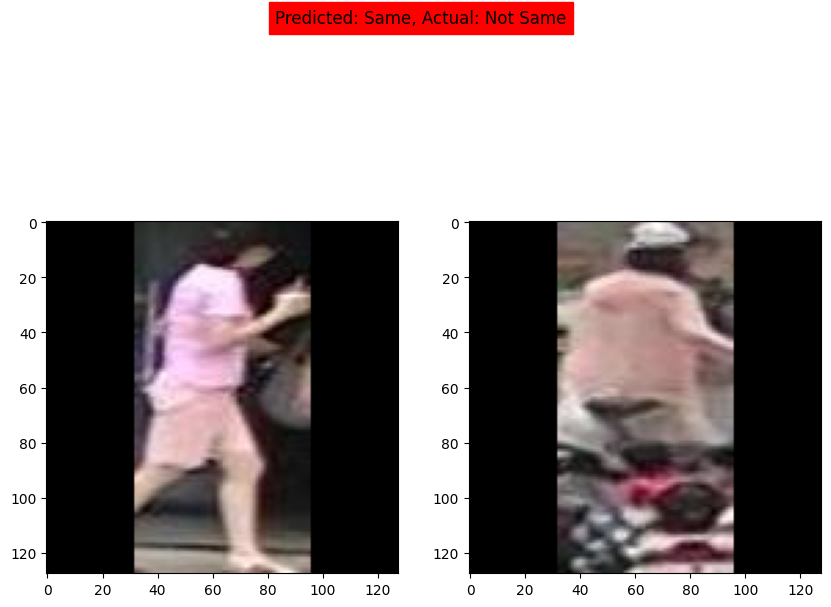

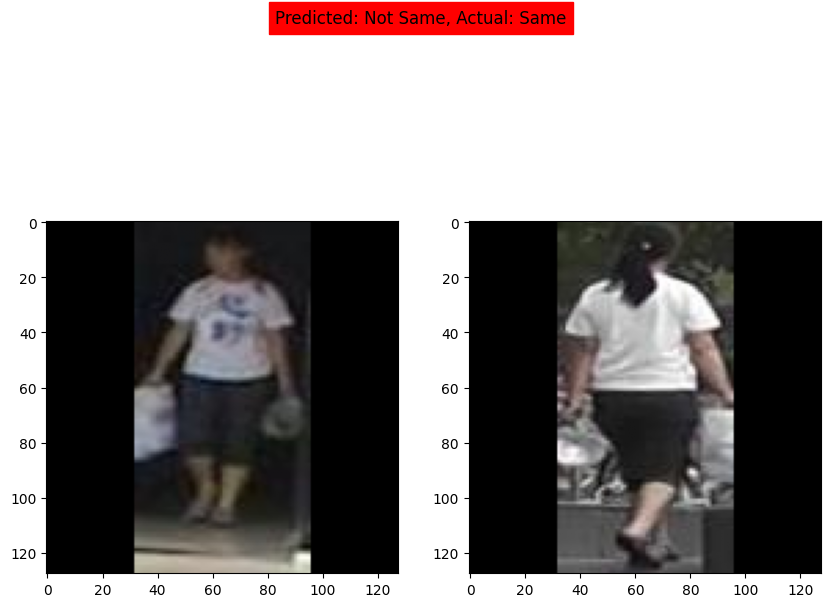

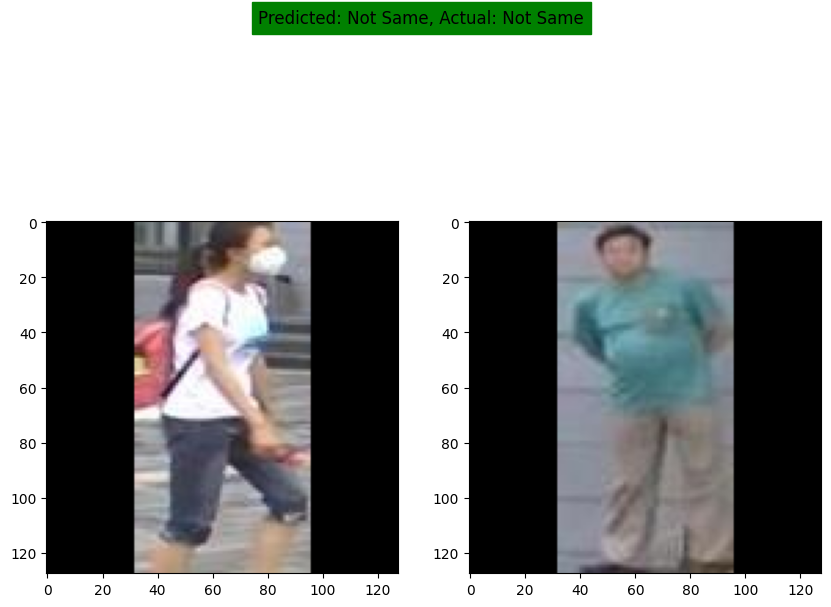

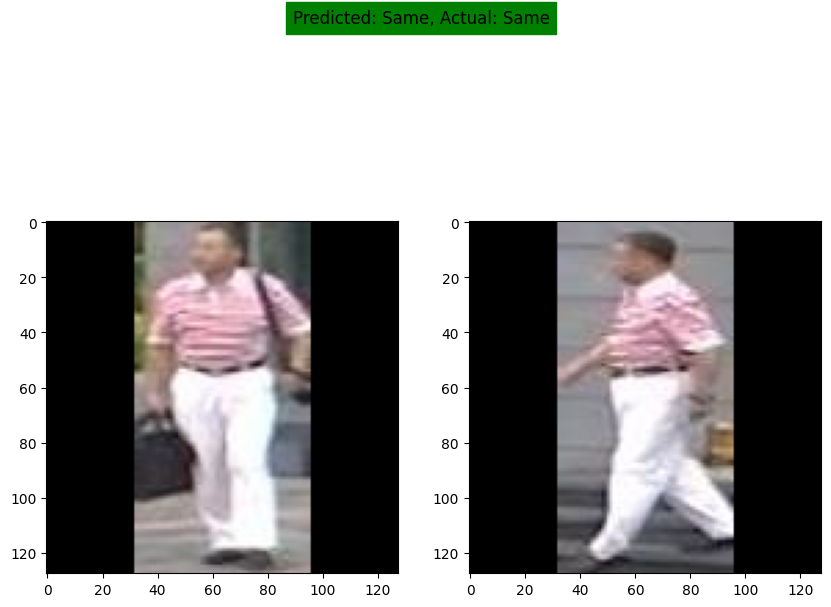

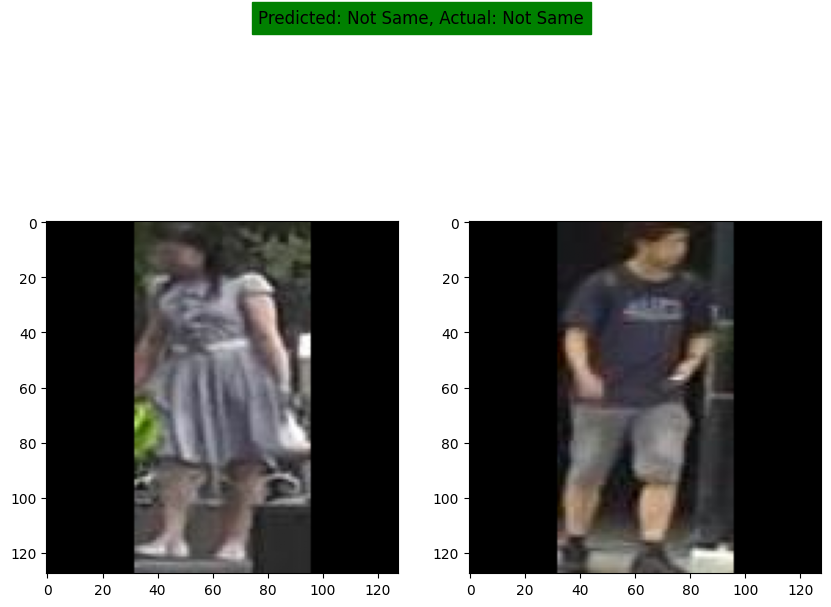

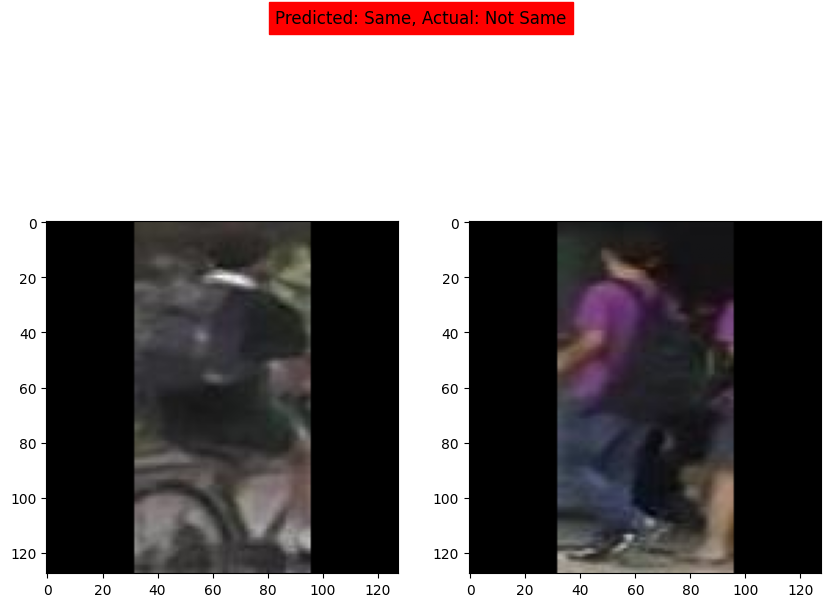

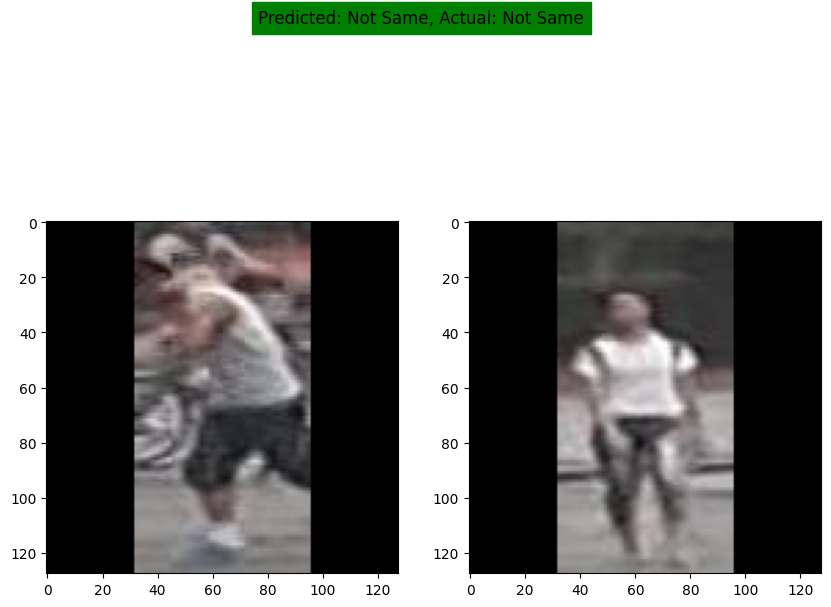

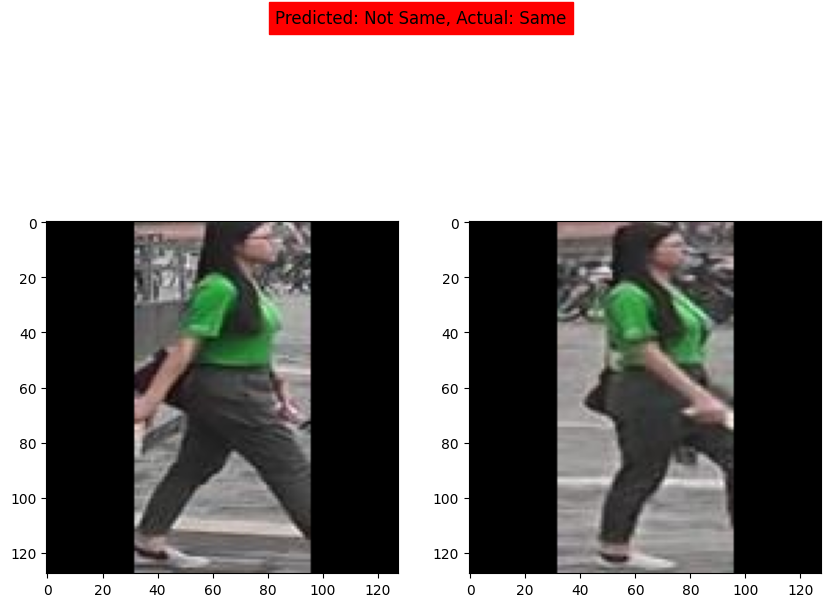

In [109]:
for i in range(16):
    plt.figure(figsize=(10, 8))
    
    predicted_title = "Same" if y_pred[i] == 1 else "Not Same"
    actual_title = "Same" if y[i] == 1 else "Not Same"

    title_color = 'green' if y_pred[i] == y[i] else 'red'

    plt.suptitle(f"Predicted: {predicted_title}, Actual: {actual_title}", backgroundcolor=title_color)

    plt.subplot(1, 2, 1)
    plt.imshow(X[0][i])

    plt.subplot(1, 2, 2)
    plt.imshow(X[1][i])

    plt.show()